using pandas, sklearn, nltk, and wordcloud to build the spam email classifier using the dataset from Kaggle

Step 0: Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Step 1: Load Dataset

In [11]:
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


Step 2: EDA

a. Common words per class

In [12]:
stop_words = set(stopwords.words('english'))

def get_top_ngrams(corpus, ngram_range=(1,1), n=10):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

for label in [0, 1]:
    print(f"\n{'Ham' if label==0 else 'Spam'}")
    top_words = get_top_ngrams(df[df.label==label]['text'], (1,1))
    print("Top Unigrams:", top_words)
    top_bigrams = get_top_ngrams(df[df.label==label]['text'], (2,2))
    print("Top Bigrams:", top_bigrams)
    top_trigrams = get_top_ngrams(df[df.label==label]['text'], (3,3))
    print("Top Trigrams:", top_trigrams)



Ham
Top Unigrams: [('gt', np.int64(318)), ('lt', np.int64(316)), ('just', np.int64(293)), ('ok', np.int64(287)), ('ll', np.int64(265)), ('ur', np.int64(241)), ('know', np.int64(236)), ('good', np.int64(233)), ('got', np.int64(232)), ('like', np.int64(232))]
Top Bigrams: [('lt gt', np.int64(276)), ('ll later', np.int64(42)), ('let know', np.int64(40)), ('sorry ll', np.int64(39)), ('good morning', np.int64(32)), ('don know', np.int64(24)), ('lt decimal', np.int64(23)), ('decimal gt', np.int64(23)), ('new year', np.int64(23)), ('pls send', np.int64(22))]
Top Trigrams: [('sorry ll later', np.int64(38)), ('lt decimal gt', np.int64(23)), ('happy new year', np.int64(18)), ('gt lt gt', np.int64(15)), ('like lt gt', np.int64(14)), ('pls send message', np.int64(13)), ('lt gt lt', np.int64(13)), ('pick phone right', np.int64(12)), ('phone right pls', np.int64(12)), ('right pls send', np.int64(12))]

Spam
Top Unigrams: [('free', np.int64(224)), ('txt', np.int64(163)), ('ur', np.int64(144)), ('mob

b. WordClouds

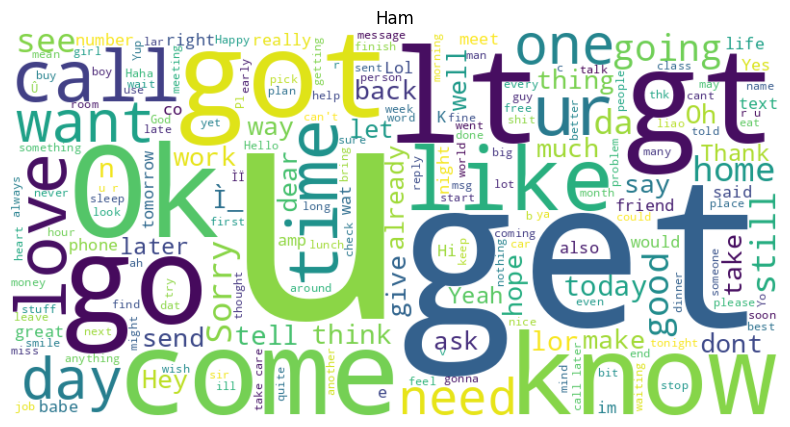

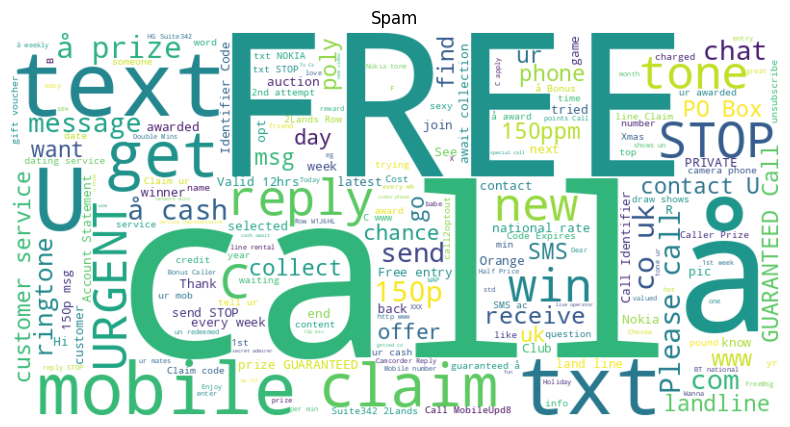

In [13]:
def plot_wordcloud(label):
    text = ' '.join(df[df.label==label]['text'])
    wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spam' if label==1 else 'Ham')
    plt.show()

plot_wordcloud(0)
plot_wordcloud(1)


Step 3: Bag of Words + Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# BoW
bow = CountVectorizer(stop_words='english')
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

model = MultinomialNB()
model.fit(X_train_bow, y_train)
pred_bow = model.predict(X_test_bow)

f1_bow = f1_score(y_test, pred_bow)
print("F1-Score (BoW):", f1_bow)


F1-Score (BoW): 0.9387755102040817


Step 4: TF-IDF + Model

In [15]:
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model.fit(X_train_tfidf, y_train)
pred_tfidf = model.predict(X_test_tfidf)

f1_tfidf = f1_score(y_test, pred_tfidf)
print("F1-Score (TF-IDF):", f1_tfidf)


F1-Score (TF-IDF): 0.8593155893536122


Step 5: Text Preprocessing + TF-IDF + Model

In [16]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

tfidf_clean = TfidfVectorizer()
X_train_clean_tfidf = tfidf_clean.fit_transform(X_train_clean)
X_test_clean_tfidf = tfidf_clean.transform(X_test_clean)

model.fit(X_train_clean_tfidf, y_train_clean)
pred_clean = model.predict(X_test_clean_tfidf)

f1_clean = f1_score(y_test_clean, pred_clean)
print("F1-Score (TF-IDF + Preprocessing):", f1_clean)


F1-Score (TF-IDF + Preprocessing): 0.8593155893536122


Step 6: Final Summary

In [17]:
summary_df = pd.DataFrame({
    "Method": ["Bag-of-Words", "TF-IDF", "TF-IDF + Preprocessing"],
    "F1-Score": [f1_bow, f1_tfidf, f1_clean]
})

print(summary_df)


                   Method  F1-Score
0            Bag-of-Words  0.938776
1                  TF-IDF  0.859316
2  TF-IDF + Preprocessing  0.859316


Step 7: Add SVM Model for Comparison


We’ll repeat the same three experiments (BoW, TF-IDF, and TF-IDF + preprocessing) using SVM (Support Vector Machine) with a linear kernel and visualize the comparison.

In [18]:
from sklearn.svm import LinearSVC

svm_bow = LinearSVC()
svm_bow.fit(X_train_bow, y_train)
pred_svm_bow = svm_bow.predict(X_test_bow)
f1_svm_bow = f1_score(y_test, pred_svm_bow)
print("F1-Score (SVM + BoW):", f1_svm_bow)


F1-Score (SVM + BoW): 0.9214285714285714


SVM with TF-IDF

In [19]:
svm_tfidf = LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train)
pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
f1_svm_tfidf = f1_score(y_test, pred_svm_tfidf)
print("F1-Score (SVM + TF-IDF):", f1_svm_tfidf)


F1-Score (SVM + TF-IDF): 0.916083916083916


SVM with TF-IDF + Preprocessing

In [20]:
svm_clean = LinearSVC()
svm_clean.fit(X_train_clean_tfidf, y_train_clean)
pred_svm_clean = svm_clean.predict(X_test_clean_tfidf)
f1_svm_clean = f1_score(y_test_clean, pred_svm_clean)
print("F1-Score (SVM + TF-IDF + Preprocessing):", f1_svm_clean)


F1-Score (SVM + TF-IDF + Preprocessing): 0.9110320284697508


Final Results Comparison Table

In [21]:
summary_df = pd.DataFrame({
    "Method": [
        "Naive Bayes + BoW", "Naive Bayes + TF-IDF", "Naive Bayes + TF-IDF + Preprocessing",
        "SVM + BoW", "SVM + TF-IDF", "SVM + TF-IDF + Preprocessing"
    ],
    "F1-Score": [f1_bow, f1_tfidf, f1_clean, f1_svm_bow, f1_svm_tfidf, f1_svm_clean]
})
print(summary_df)


                                 Method  F1-Score
0                     Naive Bayes + BoW  0.938776
1                  Naive Bayes + TF-IDF  0.859316
2  Naive Bayes + TF-IDF + Preprocessing  0.859316
3                             SVM + BoW  0.921429
4                          SVM + TF-IDF  0.916084
5          SVM + TF-IDF + Preprocessing  0.911032


Visualization of Results

/tmp/ipython-input-24-4103624182.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df.sort_values(by='F1-Score'), x='F1-Score', y='Method', palette="mako")
/tmp/ipython-input-24-4103624182.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


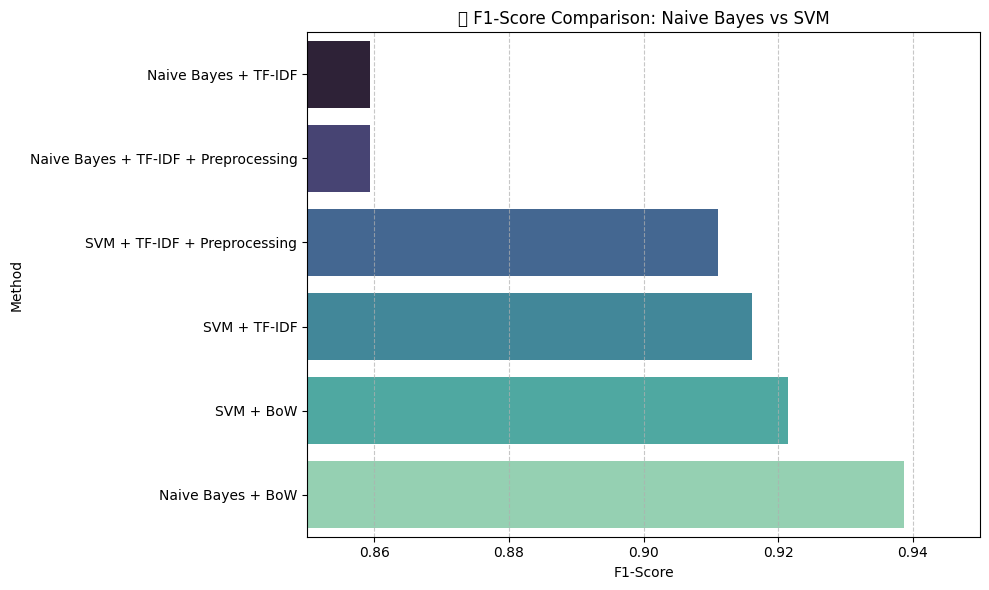

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10,6))
sns.barplot(data=summary_df.sort_values(by='F1-Score'), x='F1-Score', y='Method', palette="mako")
plt.title("📊 F1-Score Comparison: Naive Bayes vs SVM")
plt.xlabel("F1-Score")
plt.ylabel("Method")
plt.xlim(0.85, 0.95)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In this spam detection task, Naive Bayes with Bag-of-Words (BoW) emerged as the best performer (F1-score: 0.9388), indicating that raw word counts capture strong spam signals effectively. Interestingly, TF-IDF underperformed with Naive Bayes, dropping nearly 8% in F1-score—likely because TF-IDF downweights frequent spam-indicative terms that Naive Bayes relies on. On the other hand, SVM showed consistent performance across all vectorization methods, benefiting from its ability to handle high-dimensional sparse data like TF-IDF. Surprisingly, heavy text preprocessing did not yield significant improvements for either model; in fact, over-cleaning may have removed valuable patterns, especially given how spam often contains intentionally obfuscated terms (e.g., "Fr33", "W1n"). In practice, Naive Bayes + BoW is ideal for fast, lightweight applications, while SVM + TF-IDF suits scenarios where robustness and generalization are priorities. Ultimately, minimal preprocessing combined with well-chosen vectorization often beats aggressive cleaning in spam detection.

